In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

# 表示の幅を広げる
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)
rcParams['figure.figsize'] = 10, 10 # グラフが見きれないようにするためサイズを大きくしておく

# 住宅情報(2015年)

In [2]:
!pip install mojimoji
import mojimoji

In [51]:
URL0= "https://raw.githubusercontent.com/idosatoshi0118/python/main/%E5%B0%8F%E5%A3%B2%E7%B3%BB%E4%BC%81%E6%A5%AD%E3%82%A4%E3%83%B3%E3%82%BF%E3%83%BC%E3%83%B3/2015%E5%9B%BD%E6%94%BF%E8%AA%BF%E6%9F%BB%E3%83%BB%E5%B0%8F%E5%9C%B0%E5%9F%9F%E9%9B%86%E8%A8%88.csv"
kokuzei0 = pd.read_csv(URL0, low_memory=False)
kokuzei0 = kokuzei0[kokuzei0["市区町村名"].str.endswith('区')]
    
# "丁"を削除し数値のみにする
new = kokuzei0['字・丁目名'] .str.split("丁", n = 1, expand = True) 

# 欠損値を0に置換
new.fillna({0:0}, inplace=True) 
kokuzei0["字・丁目名"] = new[0]

# int型をstr型に変換し、全角数字を半角数字にする
kokuzei0['字・丁目名'] = kokuzei0['字・丁目名'].astype('str')
kokuzei0['字・丁目名'] = kokuzei0["字・丁目名"].apply(mojimoji.zen_to_han)

# 必要な項目のみ抽出
on = ["都道府県名","市区町村名","大字・町名","字・丁目名","一般世帯総数（住居の種類・住宅の所有の関係）","住宅に住む一般世帯","主世帯","持ち家",
      "民営の借家","給与住宅","住宅に住む一般世帯.1","主世帯.1","持ち家.1"]
kokuzei2 = kokuzei0[on]

kokuzei2['大字・町名'] = kokuzei2["大字・町名"].str.replace("鴬谷町","鶯谷町")
kokuzei2[kokuzei2["大字・町名"] == "鶯谷町"].head()

<ipython-input-51-e9b68afcb89b>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kokuzei2['大字・町名'] = kokuzei2["大字・町名"].str.replace("鴬谷町","鶯谷町")


,都道府県名,市区町村名,大字・町名,字・丁目名,一般世帯総数（住居の種類・住宅の所有の関係）,住宅に住む一般世帯,主世帯,持ち家,民営の借家,給与住宅,住宅に住む一般世帯.1,主世帯.1,持ち家.1
2058,東京都,渋谷区,鶯谷町,0,995,974,961,552,386,23,1816,1794,1097


# 世帯所得情報（2015）

In [115]:
URL1 = "https://raw.githubusercontent.com/idosatoshi0118/python/main/%E5%B0%8F%E5%A3%B2%E7%B3%BB%E4%BC%81%E6%A5%AD%E3%82%A4%E3%83%B3%E3%82%BF%E3%83%BC%E3%83%B3/%E6%9D%B1%E4%BA%AC%E9%83%BD%E4%B8%96%E5%B8%AF%E5%8F%8E%E5%85%A52015.csv"
TYO_income = pd.read_csv(URL1, low_memory=False) #from e-stat
TYO_income.rename(columns={'市区町村':'市区町村名'}, inplace = True) #ラベル名変更

In [35]:
#rich_nbhd["字・丁目名"]

# 高級住宅街のリスト

In [116]:
URL2 = 'https://raw.githubusercontent.com/idosatoshi0118/python/main/%E5%B0%8F%E5%A3%B2%E7%B3%BB%E4%BC%81%E6%A5%AD%E3%82%A4%E3%83%B3%E3%82%BF%E3%83%BC%E3%83%B3/%E3%82%A8%E3%83%AA%E3%82%A2(%E5%8C%BA)%E3%81%93%E3%82%99%E3%81%A8%E3%81%AE%E8%B2%B7%E5%8F%96%E7%B7%8F%E9%A1%8D%20-%20%E9%AB%98%E7%B4%9A%E6%8C%81%E3%81%A1%E5%AE%B6%E3%82%A8%E3%83%AA%E3%82%A2.csv'
dff = pd.read_csv(URL2, low_memory=False)
dff["市区町村名"] = dff["市区町村名"] + "区"

# 必要な要素のみ抽出
on = ["市区町村名","大字・町名","字・丁目名"]
rich_nbhd = dff[on]

# 欠損値の補完
rich_nbhd.fillna({'字・丁目名':0}, inplace=True)
rich_nbhd["字・丁目名"] = rich_nbhd["字・丁目名"].astype(int)
rich_nbhd["字・丁目名"] = rich_nbhd["字・丁目名"].astype(str)

/Users/satoshiido/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-116-e31e6c1aa6a9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rich_nbhd["字・丁目名"] = rich_nbhd["字・丁目名"].astype(int)
<ipython-input-116-e31e6c1aa6a9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

# 各dfを結合させる 

In [117]:
df0 = pd.merge(rich_nbhd, TYO_income, on='市区町村名', how='left')
df1 = pd.merge(df0, kokuzei2, on = ["市区町村名", "大字・町名", "字・丁目名"], how='left')

## 必要な情報を追加する

In [118]:
# 55才以上の割合
df1['45~64才の割合']  = (df1["55〜64"] + df1["45〜54"]) / df1["普通世帯総数"]
df1['65才以上の割合'] = df1["65歳以上"] / df1["普通世帯総数"]

# 1000万以上の割合
df1['1000万以上の割合'] = df1["1000万円以上"] / (df1["300万円未満"]+df1["300〜500"]+df1["500〜700"]+df1["700〜1000"]+df1["1000万円以上"])

# 持ち家比率を計算（これが企業と個人で混在している可能性はある）
df1["主世帯"] = df1["主世帯"].astype(int)
df1["持ち家"] = df1["持ち家"].astype(int)
df1["持ち家比率"] = df1['持ち家'] / df1['主世帯']

# 自営業主比率を計算
df1['自営業主比率'] = df1['自営業主'] / (df1['自営業主']+df1['雇用者']+df1['無職']+df1['その他'])

#後で結合するために"住所1"列を作成
df1['住所1'] = df1['大字・町名'].str.cat(df1['字・丁目名'])

# 統計分析

In [54]:
from scipy import stats as ss
from scipy.stats import zscore

In [120]:
df1.head()

,市区町村名,大字・町名,字・丁目名,ID,県,普通世帯総数,25歳未満,25〜34歳,35〜44,45〜54,55〜64,65歳以上,自営業主,農林・漁業業主,商工・その他の業主,雇用者,会社・団体・公社又は個人に雇われている者,官公庁,労働者派遣事業所の派遣社員,パート・アルバイト・その他,無職,学生,その他,300万円未満,300〜500,500〜700,700〜1000,1000万円以上,都道府県名,一般世帯総数（住居の種類・住宅の所有の関係）,住宅に住む一般世帯,主世帯,持ち家,民営の借家,給与住宅,住宅に住む一般世帯.1,主世帯.1,持ち家.1,45~64才の割合,65才以上の割合,1000万以上の割合,持ち家比率,自営業主比率,住所1
0,品川区,東五反田,1,109,東京都,198710,6420,26790,37340,29030,28590,52240,15270,80,15190,73440,57820,2050,2660,10910,27270,800,26460,52130,47130,30550,28000,23770,東京都,1733,1723,1713,595,1065,53,2641,2623,1131,0.28997,0.262896,0.130906,0.347344,0.107203,東五反田1
1,品川区,東五反田,3,109,東京都,198710,6420,26790,37340,29030,28590,52240,15270,80,15190,73440,57820,2050,2660,10910,27270,800,26460,52130,47130,30550,28000,23770,東京都,1178,1173,1166,601,537,28,2088,2074,1309,0.28997,0.262896,0.130906,0.515437,0.107203,東五反田3
2,品川区,東五反田,4,109,東京都,198710,6420,26790,37340,29030,28590,52240,15270,80,15190,73440,57820,2050,2660,10910,27270,800,26460,52130,47130,30550,28000,23770,東京都,1385,1382,1371,648,615,108,2403,2382,1418,0.28997,0.262896,0.130906,0.472648,0.107203,東五反田4
3,品川区,東五反田,5,109,東京都,198710,6420,26790,37340,29030,28590,52240,15270,80,15190,73440,57820,2050,2660,10910,27270,800,26460,52130,47130,30550,28000,23770,東京都,1872,1705,1687,908,599,180,3105,3072,1894,0.28997,0.262896,0.130906,0.538234,0.107203,東五反田5
4,品川区,北品川,3,109,東京都,198710,6420,26790,37340,29030,28590,52240,15270,80,15190,73440,57820,2050,2660,10910,27270,800,26460,52130,47130,30550,28000,23770,東京都,1864,1819,1802,692,917,193,3439,3406,1473,0.28997,0.262896,0.130906,0.384018,0.107203,北品川3


In [122]:
# 標準化
df1['45~64才の割合(標準化)'] = zscore(df1['45~64才の割合'])
df1['65才以上の割合(標準化)'] = zscore(df1['65才以上の割合'])
df1['1000万以上の割合(標準化)'] = zscore(df1['1000万以上の割合'])
df1['持ち家比率(標準化)'] = zscore(df1['持ち家比率'])
df1['自営業主比率(標準化)'] = zscore(df1['自営業主比率'])

# 分析に必要な要素のみ抽出
df2 = df1.iloc[:,[0,1,2,-6,-5,-4,-3,-2,-1,]]
df2.head()

,市区町村名,大字・町名,字・丁目名,住所1,45~64才の割合(標準化),65才以上の割合(標準化),1000万以上の割合(標準化),持ち家比率(標準化),自営業主比率(標準化)
0,品川区,東五反田,1,東五反田1,0.4417,0.783892,-0.716098,-1.497389,-1.339928
1,品川区,東五反田,3,東五反田3,0.4417,0.783892,-0.716098,-0.069666,-1.339928
2,品川区,東五反田,4,東五反田4,0.4417,0.783892,-0.716098,-0.433105,-1.339928
3,品川区,東五反田,5,東五反田5,0.4417,0.783892,-0.716098,0.123956,-1.339928
4,品川区,北品川,3,北品川3,0.4417,0.783892,-0.716098,-1.185894,-1.339928


In [123]:
df3 = df1.iloc[:,[-5,-4,-3,-2,-1]]
df3.head()

,45~64才の割合(標準化),65才以上の割合(標準化),1000万以上の割合(標準化),持ち家比率(標準化),自営業主比率(標準化)
0,0.4417,0.783892,-0.716098,-1.497389,-1.339928
1,0.4417,0.783892,-0.716098,-0.069666,-1.339928
2,0.4417,0.783892,-0.716098,-0.433105,-1.339928
3,0.4417,0.783892,-0.716098,0.123956,-1.339928
4,0.4417,0.783892,-0.716098,-1.185894,-1.339928


## 基本情報の可視化

<ipython-input-109-6bf7c5776323>:9: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show() # グラフの表示


Text(22.875, 0.5, 'エリア累数')

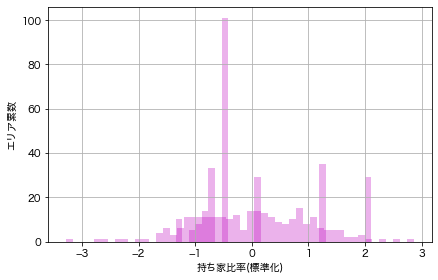

In [109]:
import matplotlib as mpl
import matplotlib.font_manager
mpl.rcParams['font.family'] = 'Hiragino Sans'

fig = plt.figure()
df2['自営業主比率(標準化)'].hist(bins=30,alpha=0.3, histtype='stepfilled', color='m', label='A')
plt.xlabel("自営業主比率(標準化)")
plt.tight_layout() # グラフ同士が重ならないようにする関数
plt.show() # グラフの表示

df2['持ち家比率(標準化)'].hist(bins=50,alpha=0.3, histtype='stepfilled', color='m', label='A')
plt.xlabel("持ち家比率(標準化)")
plt.ylabel("エリア累数")

## クラスタリング

In [73]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit(df3)
df2['クラスター番号'] = clusters.labels_
print(df2['クラスター番号'].unique()) # 付与したクラスターの番号を表示
df2.head()

[0 4 1 3 2]


<ipython-input-73-12cfc322a6e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['クラスター番号'] = clusters.labels_


,市区町村名,大字・町名,字・丁目名,住所1,45~64才の割合(標準化),65才以上の割合(標準化),1000万以上の割合(標準化),持ち家比率(標準化),自営業主比率(標準化),クラスター番号
0,品川区,東五反田,1,東五反田1,0.4417,0.783892,-0.716098,-1.497389,-1.339928,0
1,品川区,東五反田,3,東五反田3,0.4417,0.783892,-0.716098,-0.069666,-1.339928,4
2,品川区,東五反田,4,東五反田4,0.4417,0.783892,-0.716098,-0.433105,-1.339928,4
3,品川区,東五反田,5,東五反田5,0.4417,0.783892,-0.716098,0.123956,-1.339928,4
4,品川区,北品川,3,北品川3,0.4417,0.783892,-0.716098,-1.185894,-1.339928,0


In [66]:
#df2.to_excel('クラスタリング結果.xlsx') #エクセルにアウトプット

### クラスタリングの可視化

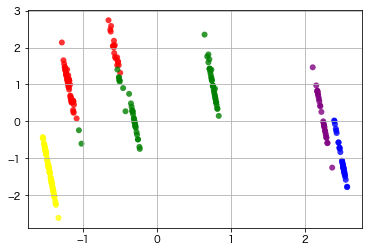

In [81]:
from sklearn.decomposition import PCA
X = df3
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["クラスター番号"] = df2["クラスター番号"]

import matplotlib.pyplot as plt
%matplotlib inline
colors = ['red','blue','yellow','purple','green']
for i in df2["クラスター番号"].unique():
    tmp = pca_df.loc[pca_df["クラスター番号"] == i]
    plt.scatter(tmp[0],tmp[1],alpha=0.8, c=colors[i], edgecolors='none')
    plt.grid(True)

In [103]:
#各クラスターごとの平均
a = df2.groupby('クラスター番号').mean()
aa = a.transpose()

<Figure size 432x288 with 0 Axes>

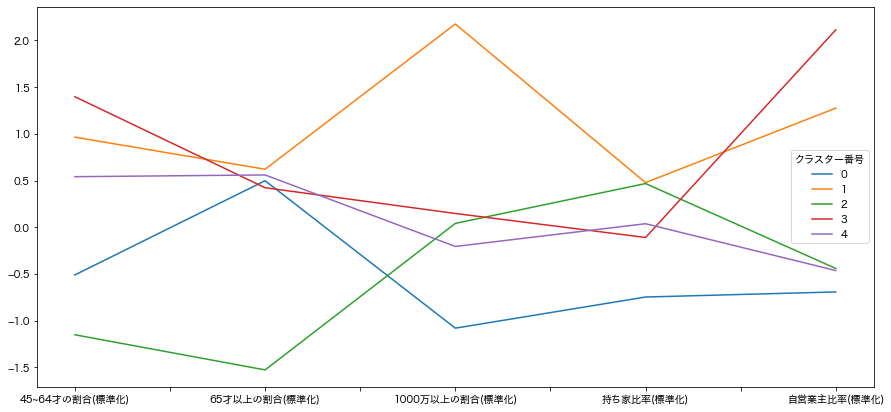

In [110]:
# プロットした図を出力
matplotlib.use('Agg') 
fig = plt.figure()

fig, ax = plt.subplots(figsize=(15,7))
aa.plot(ax=ax)

plt.savefig('figure1.png')

# 地図上で色分け
geopandasをインストール

In [ ]:
conda install geopandas

In [82]:
#conda install --channel conda-forge geopandas

In [83]:
#pip install geopandas

## 地図データをインストール

In [84]:
input_path = "shapefile" # 展開先フォルダ名

# e-stat 国勢調査 小地域（町丁・字等別） 東京都全域
shapefile_url = "https://www.e-stat.go.jp/gis/statmap-search/data?dlserveyId=A002005212015&code=13&coordSys=1&format=shape&downloadType=5"
shapefile_name = "tokyo.zip"

# ダウンロード
from urllib.request import urlretrieve
urlretrieve(url=shapefile_url, filename=shapefile_name)

# 解凍
import zipfile
with zipfile.ZipFile(shapefile_name) as existing_zip:
    existing_zip.extractall(input_path)

# ファイル名を取得
import os
files = os.listdir(input_path)
shapefile = [file for file in files if ".shp" in file][0]
print(f"downloaded shapefile: {shapefile}")

# 読み込み
import geopandas as gpd
shapefile_path = os.path.join(input_path, shapefile)
maps = gpd.read_file(shapefile_path, encoding='cp932')
print(f"{shapefile_path} is loaded")

# 東京都の島嶼部を除く
import pandas as pd
islands = ['大島町', '利島村', '新島村', '神津島村', '三宅村', '御蔵島村', '八丈町', '青ヶ島村', '小笠原村']
is_not_islands = [maps["CITY_NAME"] != island for island in islands]
is_not_islands = pd.concat(is_not_islands, axis=1).all(axis=1)
maps = maps.loc[is_not_islands, :]

# 陸地だけにする
maps = maps.loc[maps["HCODE"] == 8101, :]

# 23区のみに変える
maps = maps[maps['CITY_NAME'].str.contains('区')]

downloaded shapefile: h27ka13.shp
shapefile/h27ka13.shp is loaded


In [85]:
# "S_NAME"列の全角数値を変換
!python3.8 -m pip install --upgrade pip # Gitから日本語変換できるライブラリをインストール
!pip install jaconv
import jaconv
L = []

for i in maps['S_NAME']:
    a = jaconv.z2h(i,digit=True, ascii=True)
    L.append(a)

maps['S_NAME'] = L

In [86]:
# 結合するために新しく結合列を作成する
new = maps['S_NAME'].str.split("丁", n = 1, expand = True)
maps['住所1'] = new[0]

## 2つのデータフレームを結合

In [87]:
df4 = df2[['住所1','クラスター番号']]

In [88]:
df5 = pd.merge(maps, df4, on='住所1', how='left')
df5['クラスター番号'].fillna(-1,inplace=True)

<Figure size 432x288 with 0 Axes>

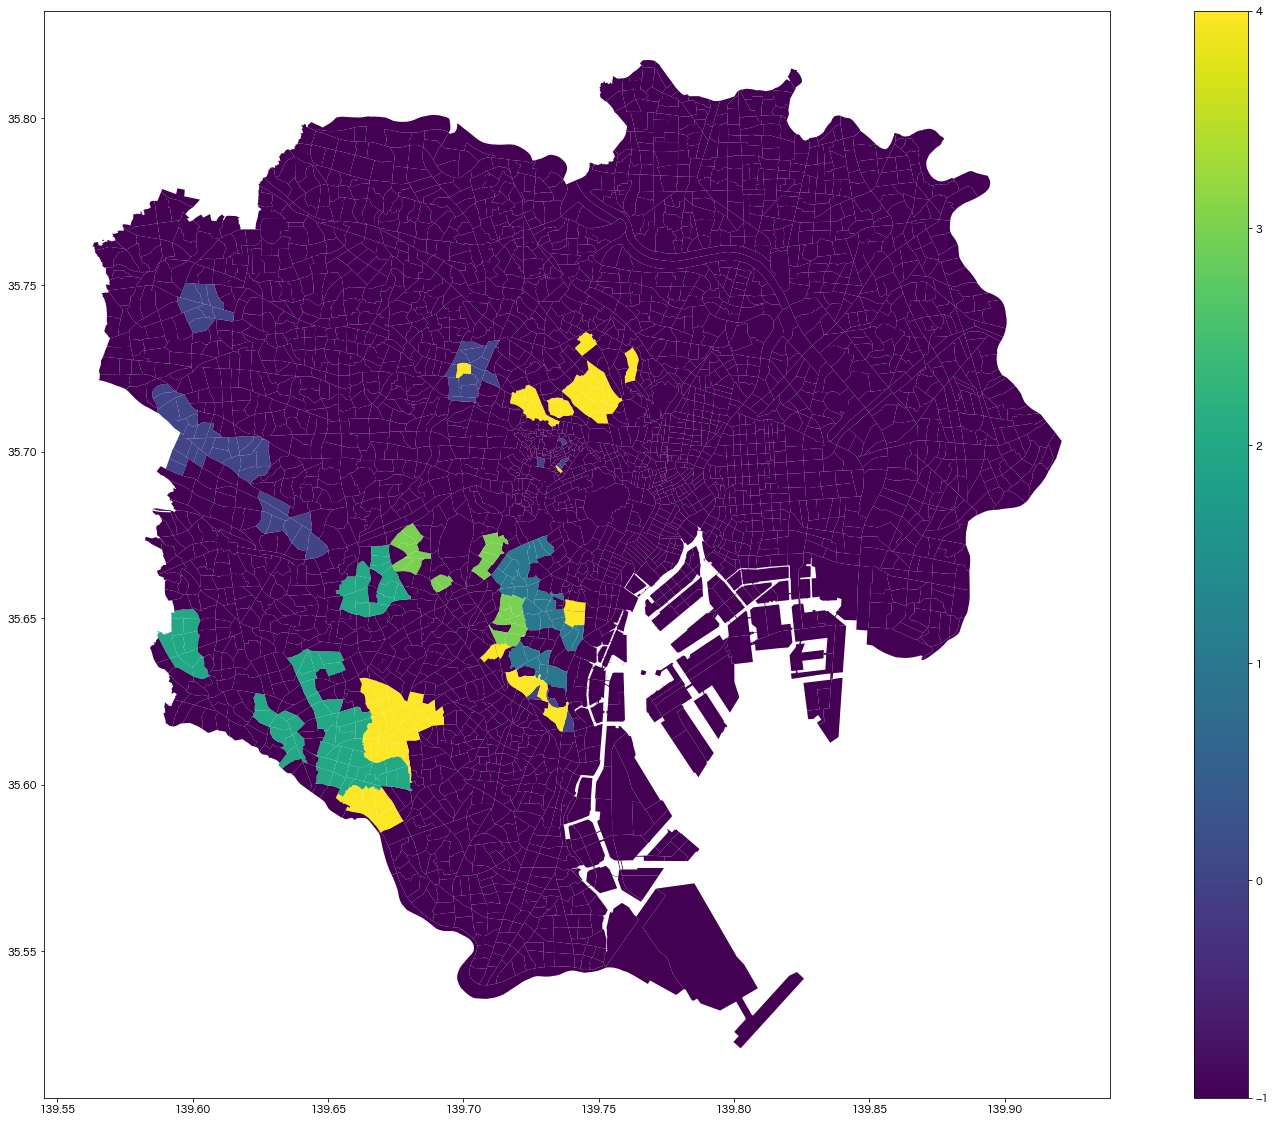

In [96]:
# プロットした図を出力
matplotlib.use('Agg') 
fig = plt.figure()

df5.plot(column= "クラスター番号", legend=True, figsize=[30,20], cmap='viridis') #色が優劣を示すものではない

plt.savefig('figure.png')

### 値のラベルをつけた図

<ipython-input-90-f8e769bd1c0b>:10: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=round(row["クラスター番号"], 2), xy=row["coords"], horizontalalignment="center")


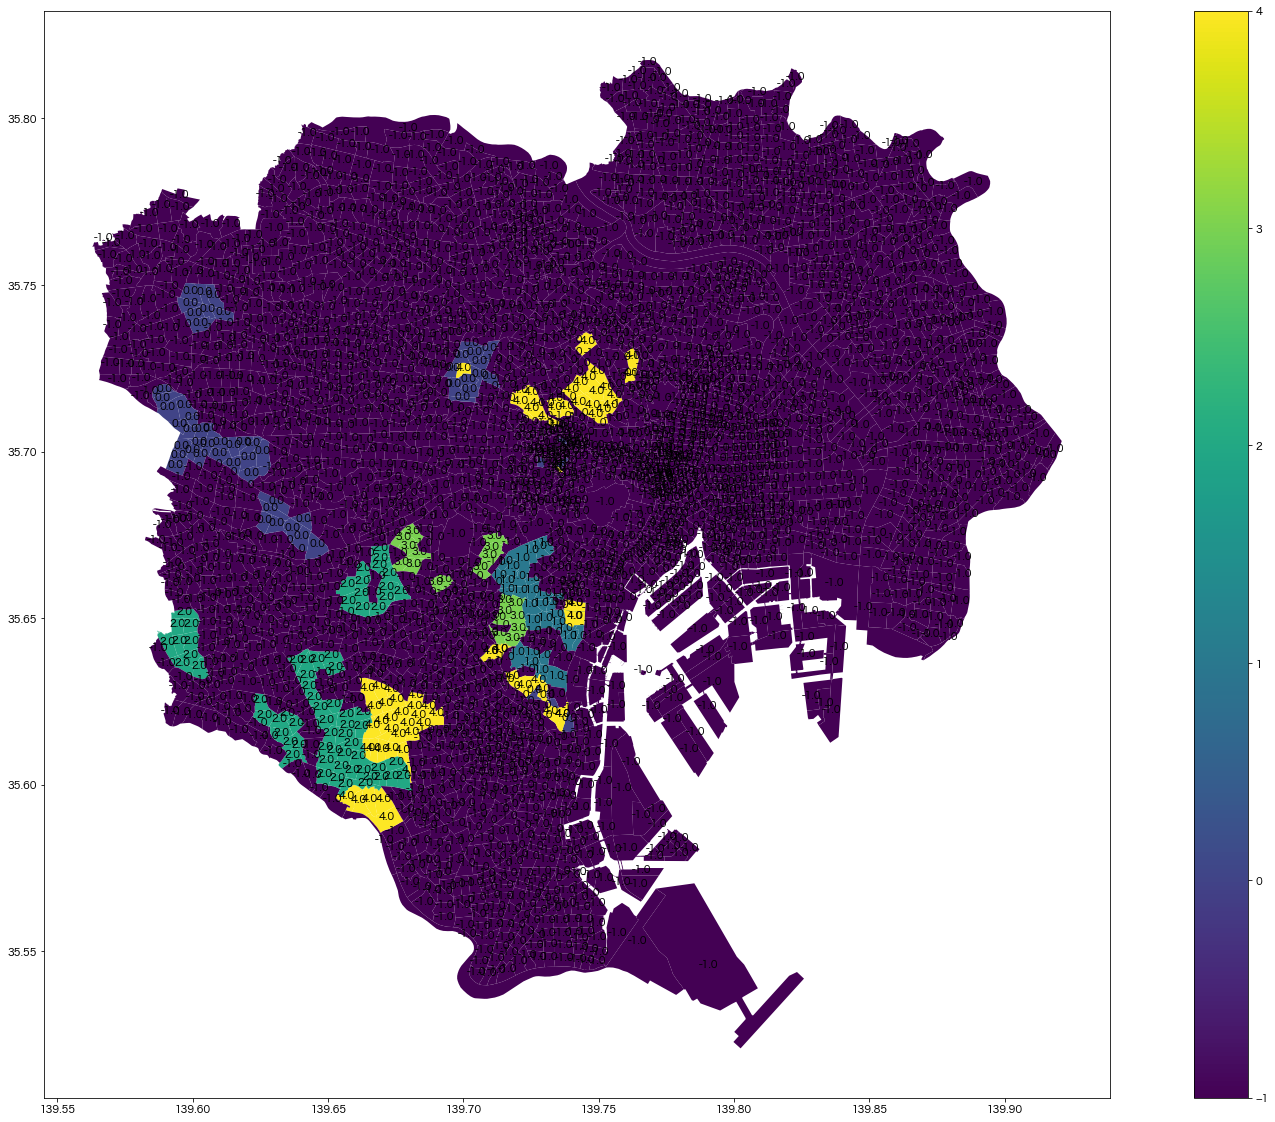

In [90]:
# 値ラベル用にgeometryから当該ポリゴン内のある地点を取得
df5["coords"] = df5["geometry"].apply(lambda x: x.representative_point().coords[:])
df5["coords"] = [coords[0] for coords in df5["coords"]]

df5.plot(column= "クラスター番号", legend=True, figsize=[30,20], cmap='viridis')

# 値ラベル
import matplotlib.pyplot as plt
for i, row in df5.iterrows():
    plt.annotate(s=round(row["クラスター番号"], 2), xy=row["coords"], horizontalalignment="center")